In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import math
from torchvision.utils import make_grid
from torchvision import transforms, datasets
import numpy as np

import sys
import os
import json

parent = os.path.dirname(os.getcwd())
sys.path.append(parent)

from models.renderer import Renderer

from pathlib import Path
import math
import importlib
import matplotlib.pyplot as plt

In [2]:
def get_options_dict(batch_size=64,
                     max_steps=200000, warmup=0, n_real=1,
                     lr=2e-4, lr_e=None, beta=(.5, .999),
                     lbd=10., lbd2=10., stroke_param=None):
    if lr_e is None:
        lr_e = lr

    return {
        "batch_size": batch_size,
        "max_steps": max_steps, "warmup": warmup,
        "n_real": n_real,
        "lr": lr, "lr_e": lr_e, "beta": beta,
        "lbd": lbd, "lbd2": lbd2,
        "stroke_param": stroke_param
    }

def get_stroke_param_dict(nlines=5, nsegments=5, line_style='bezier', smooth=False, connected=True,
                          radius=0.01, power_i=1, power_f=2,
                          enable_radius=False, enable_background=True, enable_color=True,
                          bce_color=True, bce_radius=True,
                          ):
    assert line_style in ['bezier', 'line', 'point']

    if line_style == 'bezier':
        if smooth:
            npoints = (4 + (nsegments - 1) * 2)  # 4 points + 2 for each intermediate [pt, cp]

            # this is a list of pairs of "connections" 0-1-2-3, 3-2-4-5, 5-4-6-7, ...
            coordpairs = torch.stack([torch.arange(0, npoints - 3, 2),
                                      torch.arange(1, npoints - 2, 2),
                                      torch.arange(2, npoints - 1, 2),
                                      torch.arange(3, npoints - 0, 2)], dim=1)
            coordpairs[1:, 0] += 1
            coordpairs[1:, 1] -= 1
        else:
            npoints = (4 + (nsegments - 1) * 3)  # 4 points + 3 for each intermediate [pt, cp1, cp2]

            # this is a list of pairs of "connections" 0-1-2-3, 3-4-5-6, 6-7-8-9, ...
            coordpairs = torch.stack([torch.arange(0, npoints - 3, 3),
                                      torch.arange(1, npoints - 2, 3),
                                      torch.arange(2, npoints - 1, 3),
                                      torch.arange(3, npoints - 0, 3)], dim=1)
        
        if connected:
            npoints -= 1

    elif line_style == 'line':
        npoints = nsegments + 1
        coordpairs = torch.stack([torch.arange(0, npoints - 1, 1), torch.arange(1, npoints, 1)], dim=1)
        
        if connected:
            npoints -= 1

    elif line_style == 'point':
        nsegments = 1
        npoints = 1
        coordpairs = torch.arange(0, npoints, 1).unsqueeze(1)
        connected = False

    n_positions, n_radius, n_colors, n_backgrounds = 2 * npoints, 0, 0, 0
    if enable_radius:
        n_radius = 1
    if enable_background:
        n_backgrounds = 3
    if enable_color:
        n_colors = 3

    return {
        "n_pos": n_positions,
        "n_rad": n_radius,
        "n_color": n_colors,
        "n_back": n_backgrounds,
        "n_lines": nlines,
        "n_points": npoints,
        "n_segments": nsegments,
        "coordpairs": coordpairs,
        "radius": radius,
        "power_i": power_i,
        "power_f": power_f,
        "enable_r": enable_radius,
        "enable_b": enable_background,
        "enable_c": enable_color,
        "smooth": smooth,
        "line_style": line_style,
        "bce_color": bce_color,
        "bce_radius": bce_radius,
        "connected": connected,
    }

In [3]:
from datasets import get_dataset
train_set, val_set, _, test_set, image_size = get_dataset('sketch', root='/home/hdlee/data', sketch_root='../')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [4]:
stroke_param = get_stroke_param_dict(nlines=16, nsegments=1, radius=0.0002, enable_background=False)

In [5]:
device = "cuda:0"
renderer = Renderer(image_size[0], image_size[0], stroke_param)
renderer.set_sigma2(1)

/home/hdlee/anaconda3/envs/clipasso/lib/python3.7/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352464346/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


with open("../output_sketches/stl10/path.json", "r") as f:
    paths_str = f.read()
    
paths_str = "{" + paths_str[:-2] + "}"
paths_dict = json.loads(paths_str)

import pickle

with open("../output_sketches/stl10/path_whole_color.pkl", "rb") as f:
    paths_dict = pickle.load(f)

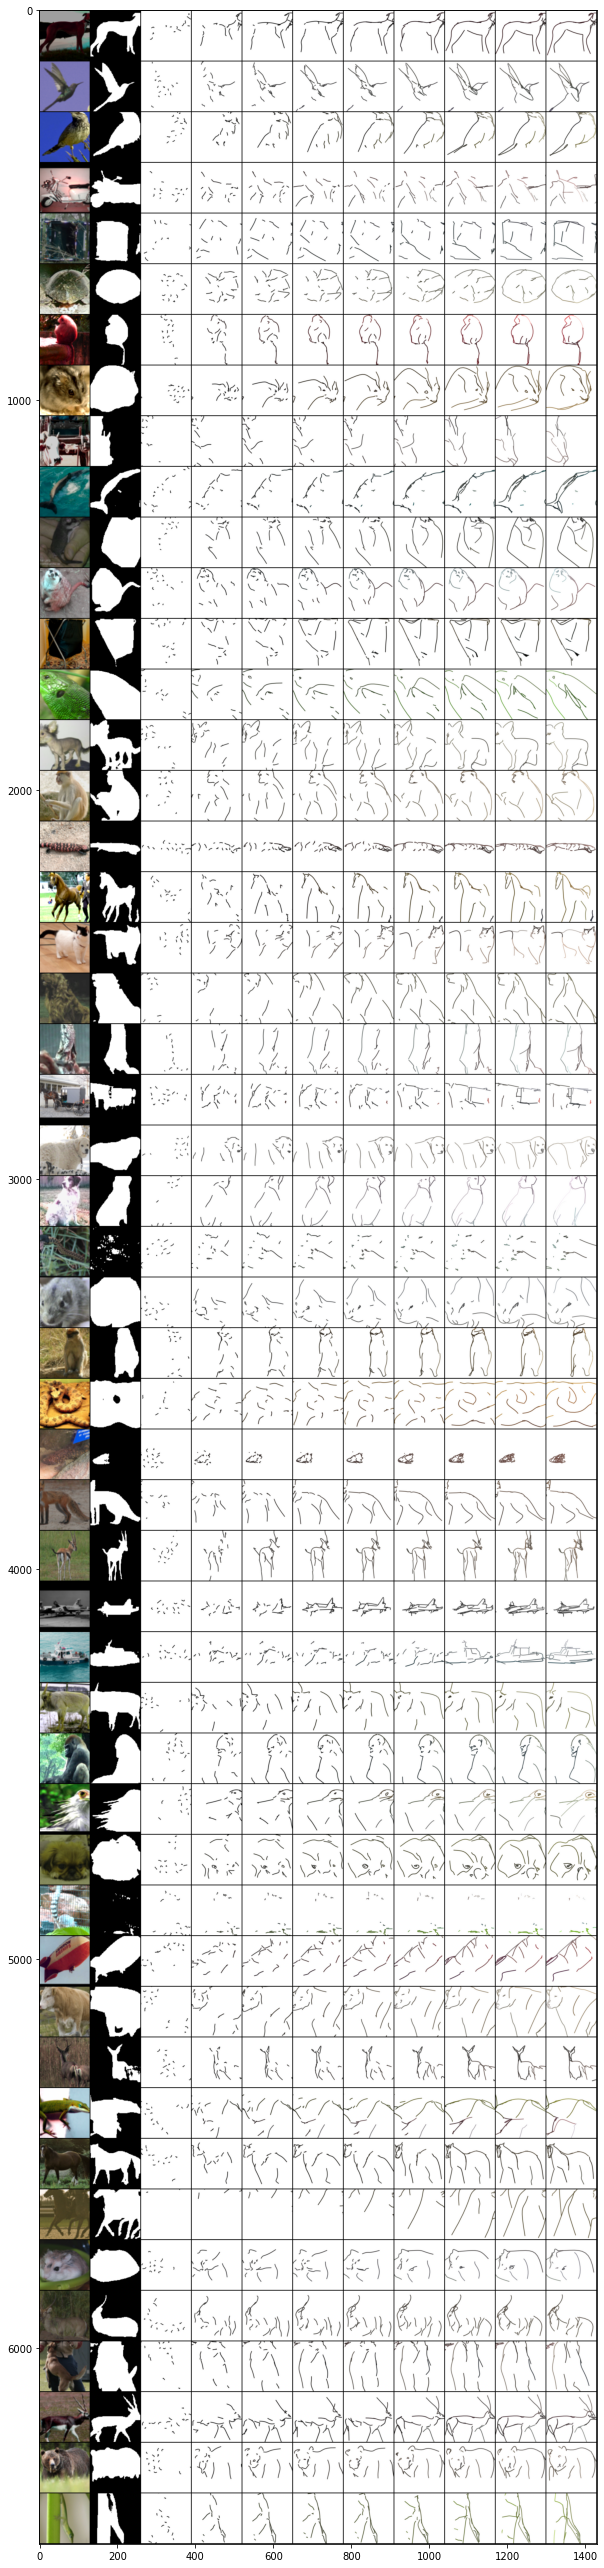

In [6]:
images = []
idx_sum = 0
for idx in range(0, 50):
        
    augmented = train_set[idx]
    image = augmented[0][0].to(device).unsqueeze(0)
    images.append(image)
    back = augmented[0][1].to(device).unsqueeze(0)
    images.append(back)

    stroke = {
        'position': [],
        'color': [],
    }

    stroke['position'] = augmented[1][0].to(device)
    stroke['position'] = torch.cat([stroke['position'], torch.ones_like(stroke['position'])[:, :4]], dim=1)
    stroke['color'] = augmented[1][1].to(device)
    stroke['color'] = torch.cat([stroke['color'], torch.ones_like(stroke['color'])[:, :4]], dim=1)

    rendered = renderer(stroke, ['color'])[0]
    images.append(rendered)

    
images = torch.cat(images).cpu()

nrow = 2 + 1 * 9
grid_num=1

f, axs = plt.subplots(1,grid_num,figsize=(10,50))
if grid_num == 1:
    axs.imshow(make_grid(images, nrow=nrow).permute(1,2,0).numpy())
else:
    for i in range(grid_num):
        axs[i].imshow(make_grid(images[(idx_sum*i)//grid_num*nrow:(idx_sum*(i+1))//grid_num*nrow], nrow=nrow).permute(1,2,0).numpy())
plt.show()

In [ ]:
augment_fn = augment.get_augment('simclr').to(device)
edge_fn = augment.get_augment('canny').to(device)

images, labels = next(train_loader)
images = images.to(device)

images = augment_fn(images)
images_s = edge_fn(images)

hidden, aux = encoder(images)
rendered_color, rendered_shape, stroke = decoder(hidden)
hidden_r, aux_r = encoder(rendered_shape)
hidden_s, aux_s = encoder(images_s)


hidden_0 = torch.stack([hidden[0], hidden_s[0], hidden_r[0], hidden[1]], dim=0)
images_0 = torch.stack([images[0], images_s[0], rendered_shape[0], images[1]], dim=0)

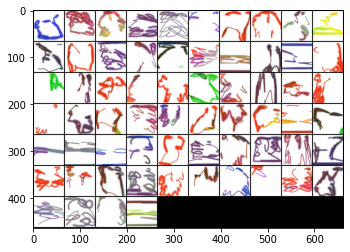

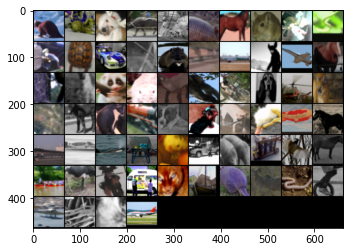

In [17]:
plt.imshow(make_grid(rendered_color.cpu(), nrow=10).permute(1,2,0).numpy())
plt.show()
plt.imshow(make_grid(images.cpu(), nrow=10).permute(1,2,0).numpy())

In [18]:
decoder.set_sigma2(1)

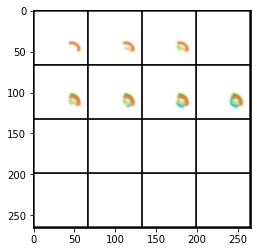

In [39]:
idx = 18

p, s, c, b, d, p_ = decoder.reshape_params(stroke)
p, s, c, b, d = p[idx:idx+1], s[idx:idx+1], c[idx:idx+1], b[idx:idx+1], d[idx:idx+1]
decision = decoder.SignWithSigmoidGrad.apply(d)

rendered = []
for i in range(p.shape[1]):
    if not decision[0, i, 0, 0]:
        rendered.append(torch.ones_like(b))
        continue
    rendered.append(decoder.render_color((p[:, :i+1], s[:, :i+1], c[:, :i+1], b), decision[:, :i+1], shape_detach=False))

rendered = torch.cat(rendered, dim=0)
plt.imshow(make_grid(rendered.cpu(), nrow=4).permute(1,2,0).numpy())

In [72]:
_, val_dsprites, _ = get_dataset('dsprites', '/home/hdlee/data/', image_size=model.image_size)
dsprites_loader = DataLoader(val_dsprites, shuffle=True, batch_size=50)

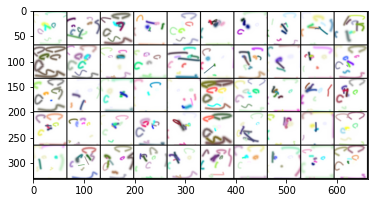

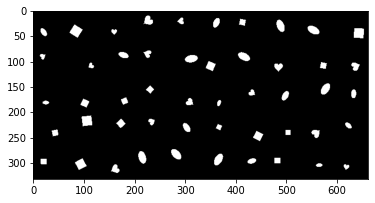

In [77]:
img, label = next(iter(dsprites_loader))
rendered_color = model(img.to(device))[0]
plt.imshow(make_grid(rendered_color.cpu(), nrow=10).permute(1,2,0).numpy())
plt.show()
plt.imshow(make_grid(img.cpu(), nrow=10).permute(1,2,0).numpy())